# Emulating CLASS data

## Import Packages

In [1]:
import os
import numpy as np
import random

import pandas as pd
import time
import matplotlib.pyplot as plt

from looti import dictlearn as dcl
from looti import datahandle as dhl
from looti import plotting as pm
from looti import tools as too

In [2]:
%matplotlib inline

In [3]:
df1 = pd.read_csv('../data/mgcamb_lhs_log10fr0.csv', index_col=list(range(14)))
df1

1  \
data_type redshift parameter_1 parameter_1_value parameter_2  parameter_2_value parameter_3 parameter_3_value parameter_4              parameter_4_value parameter_5 parameter_5_value parameter_6 parameter_6_value               
Plin      0.00     omega_m     0.312267          omega_baryon 0.046708          hubble      51.980833         scalar_spectral_index(1) 1.0712            sigma8      0.941435          log10fR0    -6.224293          120.838746   
          0.05     omega_m     0.312267          omega_baryon 0.046708          hubble      51.980833         scalar_spectral_index(1) 1.0712            sigma8      0.941435          log10fR0    -6.224293          114.964287   
          0.10     omega_m     0.312267          omega_baryon 0.046708          hubble      51.980833         scalar_spectral_index(1) 1.0712            sigma8      0.941435          log10fR0    -6.224293          108.413822   
          0.15     omega_m     0.312267          omega_baryon 0.046708          hubble      51.980833         scalar_spectral_index(1) 1.0712            sigma8      0.941435          log10fR0    -6.224293          102.266769   
          0.20     omega_m     0.312267          omega_baryon 0.046708          hubble      51.980833         scalar_spectral_index(1) 1.0712            sigma8      0.941435          log10fR0    -6.224293           96.963940   
...                                                                                                                                                                                                                          ...   
          4.85     omega_m     0.281333          omega_baryon 0.042708          hubble      76.212500         scalar_spectral_index(1) 0.7512            sigma8      0.667175          log10fR0    -6.471674           23.213930   
          4.90     omega_m     0.281333          omega_baryon 0.042708          hubble      76.212500         scalar_spectral_index(1) 0.7512            sigma8      0.667175          log10fR0    -6.471674           22.669949   
          4.95     omega_m     0.281333          omega_baryon 0.042708          hubble      76.212500         scalar_spectral_index(1) 0.7512            sigma8      0.667175          log10fR0    -6.471674           22.429898   
          5.00     omega_m     0.281333          omega_baryon 0.042708          hubble      76.212500         scalar_spectral_index(1) 0.7512            sigma8      0.667175          log10fR0    -6.471674           22.084657   
k_grid    NaN      NaN         NaN               NaN          NaN               NaN         NaN               NaN                      NaN               NaN         NaN               NaN         NaN                  0.000035   

                                                                                                                                                                                                                               2  \
data_type redshift parameter_1 parameter_1_value parameter_2  parameter_2_value parameter_3 parameter_3_value parameter_4              parameter_4_value parameter_5 parameter_5_value parameter_6 parameter_6_value               
Plin      0.00     omega_m     0.312267          omega_baryon 0.046708          hubble      51.980833         scalar_spectral_index(1) 1.0712            sigma8      0.941435          log10fR0    -6.224293          123.193211   
          0.05     omega_m     0.312267          omega_baryon 0.046708          hubble      51.980833         scalar_spectral_index(1) 1.0712            sigma8      0.941435          log10fR0    -6.224293          117.188715   
          0.10     omega_m     0.312267          omega_baryon 0.046708          hubble      51.980833         scalar_spectral_index(1) 1.0712            sigma8      0.941435          log10fR0    -6.224293          110.540549   
          0.15     omega_m     0.312267          omega_baryon 0.046708          hubble      51.980833         scalar_s

# Import Data

In [4]:
data_folder = '../data/' 
results_folder = '../results/'

In [5]:
###Name of the file for the external input data, without the extension
datafile_ext = 'mgcamb_lhs_log10fr0'
###Name of the file for the LCDM input data
datafile_ref = 'ref_mgcamb_lhs_log10fr0'

In [6]:
emulation_data = dhl.DataHandle(datafile_ext, 
                                data_folder, 
                                datafile_ref, 
                                num_parameters=6, 
                                data_type='Plin',
                                features_name='k_grid', 
                                features_to_Log=True, 
                                normalize_by_reference=True) 
emulation_data.read_csv_pandas()

## Calculate power spectra ratios at all redshifts available

In [7]:
## Set normalize=False, since Fitting Formulae are already normalized
## First argument contains all the redshifts at which simulations are available
emulation_data.calculate_ratio_by_redshifts(emulation_data.z_vals, normalize=True)

# Define number of training and test

In [8]:
### Available parameters 
n_train = 2000 # Number of training vectors without taking acount the extrema 
n_test = 2 # Number of test vectors without taking acount the extrema
n_splits = 1  # Number of splits
test_indices=[random.sample(range(1, 1000), n_test)]  ## List of list of indices, one list per split

z_list = list(np.loadtxt('../../input4cast/output/mg_camb_lhs_log10fR0/0000/z_values_list.txt'))

In [9]:
emulation_data.calculate_data_split(n_train=n_train, ##number of training vectors/ redshift
                                    n_test=n_test, ##number of test vectors
                                    n_splits=n_splits,
                                    verbosity=3,
                                    manual_split=True,
                                    test_indices=None,
                                    train_redshift_indices=list(range(5)),##Indices of the redshifts used for the train vect.
                                    test_redshift_indices=list(range(5))) ##Indices of the redshifts used for the test vect.

('number of wanted training vectors', 2000)
('number of wanted test vectors', 2)
('redshift used for training', array([0.  , 0.05, 0.1 , 0.15, 0.2 ]))
('redshfit used for testing', array([0.  , 0.05, 0.1 , 0.15, 0.2 ]))


In [10]:
emulation_data.train_redshift

array([0.  , 0.05, 0.1 , 0.15, 0.2 ])

#  PCA with GP interpolation

In [11]:
npca = 7
nparam = 7

In [12]:
ratios_predicted , emulation_data, intobj = dcl.Predict_ratio(emulation_data,Operator="PCA",
                                                              train_noise=1e-10, ##noise for the GP's kernel
                                                              gp_n_rsts=40,##times allowed to restart the optimiser
                                                              ncomp=npca, ##number of components
                                                              gp_const=1, ##Constant for the RBF kernel
                                                              gp_length=np.ones(nparam) , ## Length for GP 
                                                              interp_type='GP', ##kind of interpolator,e.g int1d or GP 
                                                              n_splits=n_splits, ##number of splits
                                                              test_indices=test_indices, ##indices of the test vectors
                                                              interp_dim=1,
                                                              return_interpolator=True,
                                                              pca_norm=True,
                                                              train_redshift_indices=list(range(5)),
                                                              test_redshift_indices=list(range(5))
                                                              # min_k =1e-2,ma_k=10e1
                                                              )

('Shape of PCA matrix: (130, 7)',)
('Number of PCA components: 7',)


In [24]:
intobj.predict_mat.shape

(10, 800)

In [13]:
# import pickle
# filename = 'gp_Plin.sav'
# pickle.dump(intobj, open(filename, 'wb'))

In [14]:
colors = plt.cm.coolwarm(np.linspace(0, 1, n_train +2))
colors_pca = plt.cm.coolwarm(np.linspace(0, 1, npca))
kgrid = emulation_data.k_grid

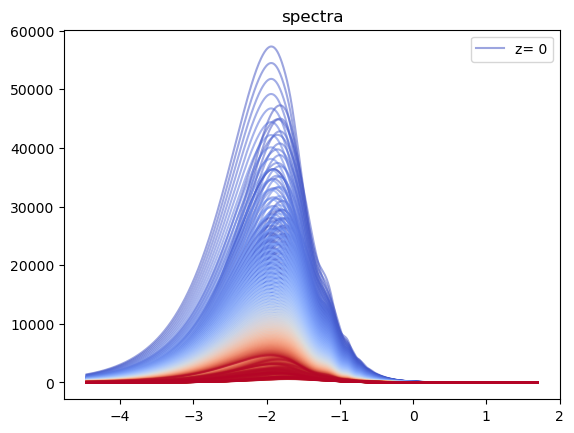

In [15]:
spectra = emulation_data.df_ext.loc['Plin'].values
for i, (spec, color) in enumerate(zip(spectra, colors)):
    if i == 0:
        plt.plot(kgrid, spec, c=color, alpha=0.5, label='z= %i' %emulation_data.z_requested[i])
    plt.plot(kgrid, spec, c=color, alpha=0.5)
plt.title('spectra')
plt.legend()

TRAINING DATA: (130, 800)


Text(0.5, 1.0, 'spectra normed')

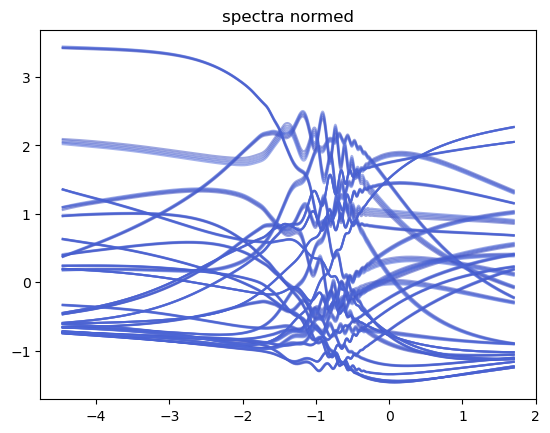

In [16]:
trainspace_matrix = intobj.trainspace_mat
print('TRAINING DATA:', trainspace_matrix.shape)
for spec, color in zip(trainspace_matrix, colors):
    plt.plot(kgrid, spec, c=color, alpha=0.5)
plt.title('spectra normed')

PCA RAW: (130, 7)


Text(0.5, 1.0, 'pca')

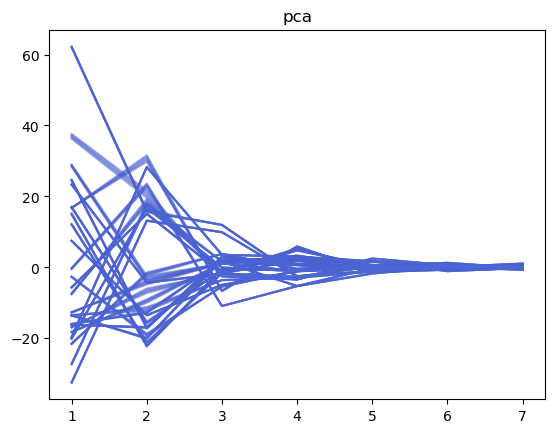

In [17]:
pca_raw = intobj.pca.fit(trainspace_matrix).transform(trainspace_matrix)
print('PCA RAW:', pca_raw.shape)
for pcar, color in zip(pca_raw, colors):
    plt.plot(np.linspace(1, npca, npca), pcar, c=color, alpha=0.5)
plt.title('pca')

PCA: (130, 7)


Text(0.5, 1.0, 'pca normed')

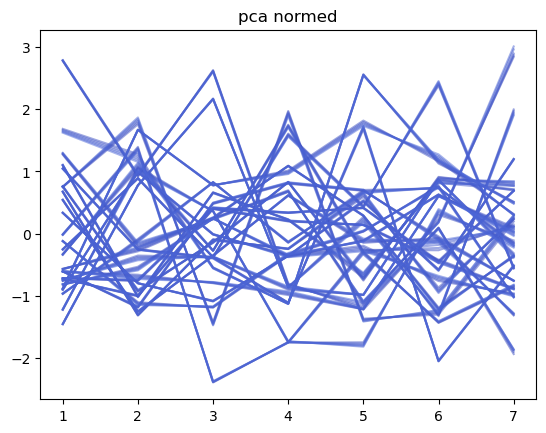

In [18]:
pca_test = intobj.representation
print('PCA:', pca_test.shape)
for pca, color in zip(pca_test, colors):
    plt.plot(np.linspace(1, npca, npca), pca, c=color, alpha=0.5)
plt.title('pca normed')

Text(0, 0.5, 'Normed Input Values')

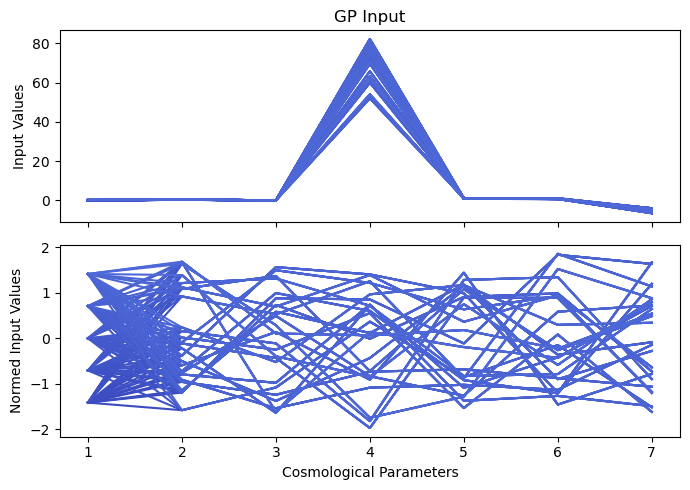

In [19]:
trainspace_raw = intobj.trainspace
trainspace_normed = (trainspace_raw - trainspace_raw.mean(axis=0)) / trainspace_raw.std(axis=0)

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)

for tsr, color in zip(trainspace_raw, colors):
    ax[0].plot(np.linspace(1, nparam, nparam), tsr, c=color)
ax[0].set_ylabel('Input Values')
ax[0].set_xticklabels([])
ax[0].set_title('GP Input')


for tsr, color in zip(trainspace_normed, colors):
    ax[1].plot(np.linspace(1, nparam, nparam), tsr, c=color)
ax[1].set_xlabel('Cosmological Parameters')
ax[1].set_ylabel('Normed Input Values')

In [37]:
plot_index = 20

Text(0, 0.5, 'Residuals')

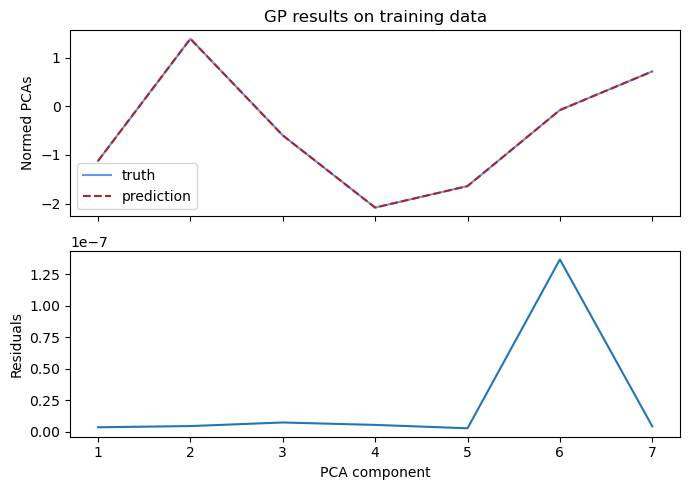

In [38]:
xtrain = (emulation_data.train_samples - emulation_data.train_samples.mean(axis=0)) / emulation_data.train_samples.std(axis=0)
prediction_pca_normed = intobj.gp_regressor.predict(xtrain)
truth_pca_normed = intobj.representation
fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(np.linspace(1, npca, npca), truth_pca_normed[plot_index], c='cornflowerblue', label='truth')
ax[0].plot(np.linspace(1, npca, npca), prediction_pca_normed[plot_index], c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Normed PCAs')
ax[0].set_xticks(np.arange(1, npca+1))
ax[0].set_xticklabels([])
ax[0].set_title('GP results on training data')

residuals = np.abs(1- (prediction_pca_normed/truth_pca_normed))
ax[1].plot(np.linspace(1, npca, npca), residuals[plot_index])
ax[1].set_xticks(np.arange(1, npca+1))
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')

Text(0, 0.5, 'Residuals')

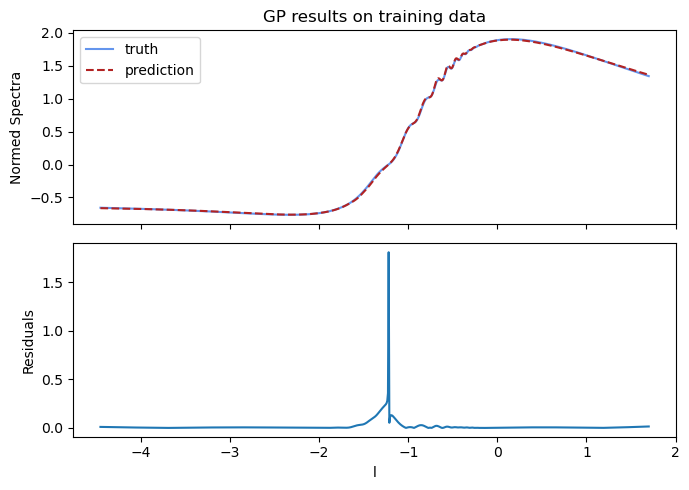

In [39]:
truth_spectrum_normed_train = intobj.trainspace_mat[plot_index]
prediction_spectrum_normed_train = intobj.reconstruct_data(emulation_data.train_samples, pca_norm=True)[plot_index]

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(kgrid, truth_spectrum_normed_train, c='cornflowerblue', label='truth')
ax[0].plot(kgrid, prediction_spectrum_normed_train, c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Normed Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on training data')

residuals = np.abs(1- (prediction_spectrum_normed_train/truth_spectrum_normed_train))
ax[1].plot(kgrid, residuals)
ax[1].set_xlabel('l')
ax[1].set_ylabel('Residuals')

In [40]:
binwise_mean = emulation_data.binwise_mean
binwise_std = emulation_data.binwise_std
# ref = emulation_data.df_ref.loc['Plin', ].values
ref = 1

Text(0, 0.5, 'Residuals')

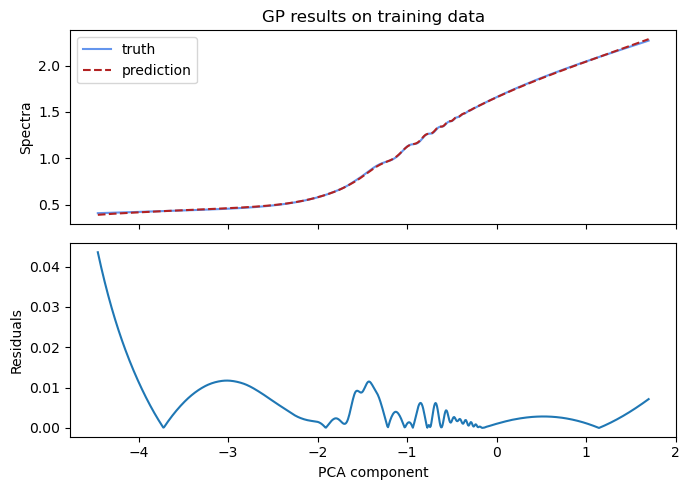

In [41]:
truth_spectrum_train = (truth_spectrum_normed_train * binwise_std + binwise_mean) * ref
prediction_spectrum_train = (prediction_spectrum_normed_train * binwise_std + binwise_mean) * ref


fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(kgrid, truth_spectrum_train.flatten(), c='cornflowerblue', label='truth')
ax[0].plot(kgrid, prediction_spectrum_train.flatten(), c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on training data')

residuals = np.abs(1 - prediction_spectrum_train.flatten() / truth_spectrum_train.flatten())
ax[1].plot(kgrid, residuals)
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')

In [44]:
plot_index = 3

In [45]:
indexvalues = emulation_data.test_samples[plot_index]

truth_spectrum = emulation_data.df_ext.loc['Plin', indexvalues[0], 'omega_m', indexvalues[1], 'omega_baryon', indexvalues[2], 'hubble', indexvalues[3], 'scalar_spectral_index(1)', indexvalues[4], 'sigma8', indexvalues[5], 'log10fR0', indexvalues[6]].values.flatten()

ref_spectrum = emulation_data.df_ref.loc['Plin', indexvalues[0]].values.flatten()
# ref_spectrum = 1

truth_spectrum_normed = (truth_spectrum/ref_spectrum - emulation_data.binwise_mean) / emulation_data.binwise_std
prediction_spectrum_normed = intobj.predict(emulation_data.test_samples, pca_norm=True)[tuple(indexvalues)]

In [46]:
indexvalues = emulation_data.test_samples[plot_index]
truth_spectrum_test = emulation_data.df_ext.loc['Plin', indexvalues[0], 
                                                'omega_m', indexvalues[1], 
                                                'omega_baryon', indexvalues[2], 
                                                'hubble', indexvalues[3], 
                                                'scalar_spectral_index(1)', indexvalues[4], 
                                                'sigma8', indexvalues[5], 
                                                'log10fR0', indexvalues[6]].values.flatten()


ref_spectrum = emulation_data.df_ref.loc['Plin', indexvalues[0]].values.flatten()

truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std

truth_pca_test1 = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
truth_pca_test = (truth_pca_test1 - intobj.matPCA_mean) / intobj.matPCA_std
xtest = (emulation_data.test_samples - intobj.trainspace_mean) / intobj.trainspace_std
prediction_pca_test, std_pca_test = intobj.gp_regressor.predict(xtest, return_std=True)

In [47]:
truth_normed_pcas_list = []

for ii in range(emulation_data.test_samples.shape[0]):
    indexvalues = emulation_data.test_samples[ii]
    truth_spectrum_test = emulation_data.df_ext.loc['Plin', indexvalues[0], 
                                                    'omega_m', indexvalues[1], 
                                                    'omega_baryon', indexvalues[2], 
                                                    'hubble', indexvalues[3], 
                                                    'scalar_spectral_index(1)', indexvalues[4], 
                                                    'sigma8', indexvalues[5], 
                                                    'log10fR0', indexvalues[6]].values.flatten()
    ref_spectrum = emulation_data.df_ref.loc['Plin', indexvalues[0]].values.flatten()



    truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std
    truth_pca_test_raw = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
    truth_pca_test = (truth_pca_test_raw - intobj.matPCA_mean) / intobj.matPCA_std
    truth_normed_pcas_list.append(truth_pca_test)

truth_normed_pcas = np.array(truth_normed_pcas_list)

IndexError: index 7 is out of bounds for axis 1 with size 7

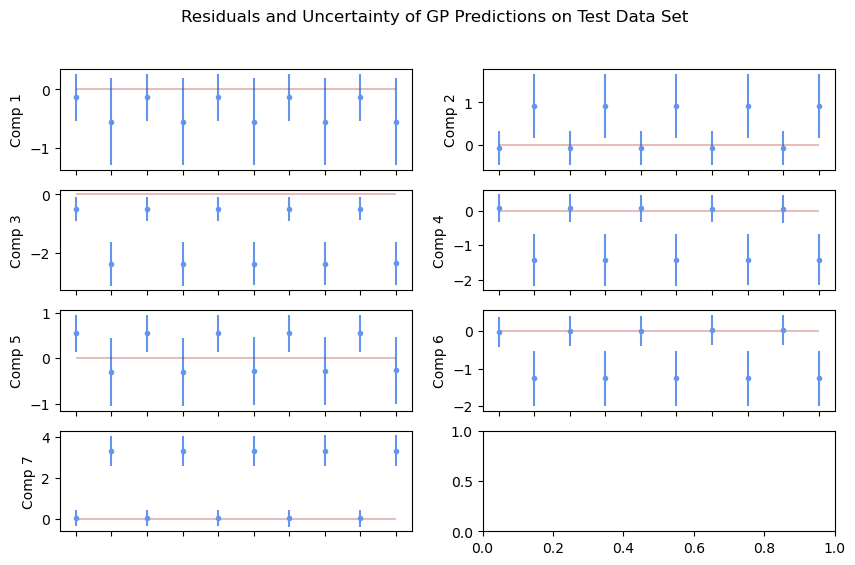

In [48]:
n_test = emulation_data.test_samples.shape[0]
grid = np.linspace(1, n_test, n_test)
fig, axs = plt.subplots(nrows=int(np.ceil(npca/2)), ncols=2, figsize=(10,6))
#plt.subplots_adjust(hspace=0.5)
fig.suptitle('Residuals and Uncertainty of GP Predictions on Test Data Set')

for comp, ax in enumerate(axs.ravel()):
    ax.errorbar(grid, 
                 truth_normed_pcas[:,comp]-prediction_pca_test[:,comp], 
                 yerr=std_pca_test[:,comp], 
                 linestyle='', marker='.', color='cornflowerblue')
    ax.hlines(0, 1, n_test, color='firebrick', alpha=0.3)

    ax.set_ylabel("Comp %i" %(comp+1))
    ax.set_xticks(list(range(1,n_test+1)))
    ax.set_xticklabels([])

for i in range(2):
    axs[-1, i].set_xlabel('Test data index')
    axs[-1, i].set_xticklabels(list(range(1, n_test+1)))

plt.tight_layout()
plt.show()

In [49]:
plot_index =0

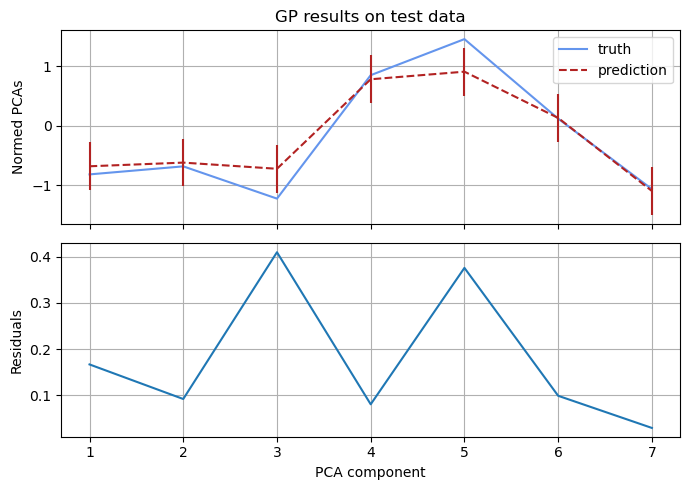

In [51]:
indexvalues = emulation_data.test_samples[plot_index]
truth_spectrum_test = emulation_data.df_ext.loc['Plin', indexvalues[0], 
                                                'omega_m', indexvalues[1], 
                                                'omega_baryon', indexvalues[2], 
                                                'hubble', indexvalues[3], 
                                                'scalar_spectral_index(1)', indexvalues[4], 
                                                'sigma8', indexvalues[5], 
                                                'log10fR0', indexvalues[6]].values.flatten()
ref_spectrum = emulation_data.df_ref.loc['Plin', indexvalues[0]].values.flatten()


truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std

truth_pca_test1 = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
truth_pca_test = (truth_pca_test1 - intobj.matPCA_mean) / intobj.matPCA_std
xtest = (emulation_data.test_samples - intobj.trainspace_mean) / intobj.trainspace_std
prediction_pca_test, std_pca_test = intobj.gp_regressor.predict(xtest, return_std=True)
# prediction_pca_test = intobj.interpolated_atoms(xtest)[plot_index]

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(np.linspace(1, npca, npca), truth_pca_test, c='cornflowerblue', label='truth')
ax[0].plot(np.linspace(1, npca, npca), prediction_pca_test[plot_index], c='firebrick', linestyle='--', label='prediction')
ax[0].errorbar(np.linspace(1, npca, npca), prediction_pca_test[plot_index], yerr=std_pca_test[plot_index], linestyle='', color='firebrick')
ax[0].legend()
ax[0].set_ylabel('Normed PCAs')
ax[0].set_xticks(np.arange(1, npca+1))
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')
ax[0].grid()

residuals_pca = np.abs(1- (prediction_pca_test[plot_index]/truth_pca_test))
ax[1].plot(np.linspace(1, npca, npca), residuals_pca)
ax[1].set_xticks(np.arange(1, npca+1))
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')
ax[1].grid()

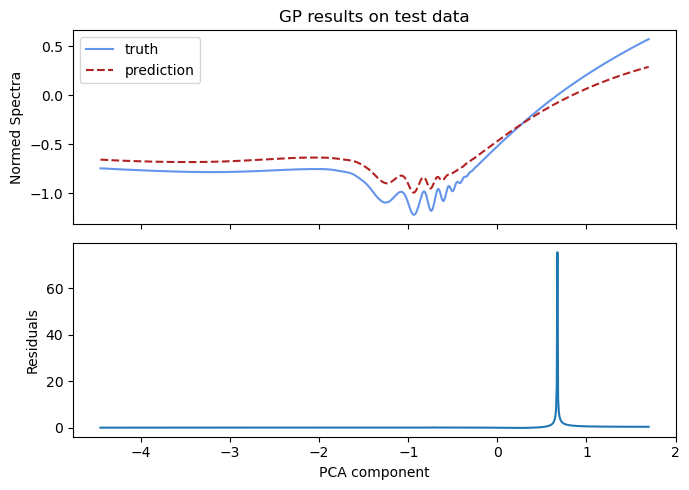

In [52]:
prediction_spectrum_normed_test = intobj.predict(emulation_data.test_samples, pca_norm=True)[tuple(indexvalues)]
# prediction_spectrum_normed = ratios_predicted[tuple(emulation_data.test_samples[plot_index])]

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(kgrid, truth_spectrum_normed_test, c='cornflowerblue', label='truth')
ax[0].plot(kgrid, prediction_spectrum_normed_test, c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Normed Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')
# ax[0].hlines(0, 1, 2499, color='black', alpha=0.3)

residuals_norm = np.abs(1 - prediction_spectrum_normed_test / truth_spectrum_normed_test)
ax[1].plot(kgrid, residuals_norm)
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')
plt.show()

Text(0, 0.5, 'Residuals')

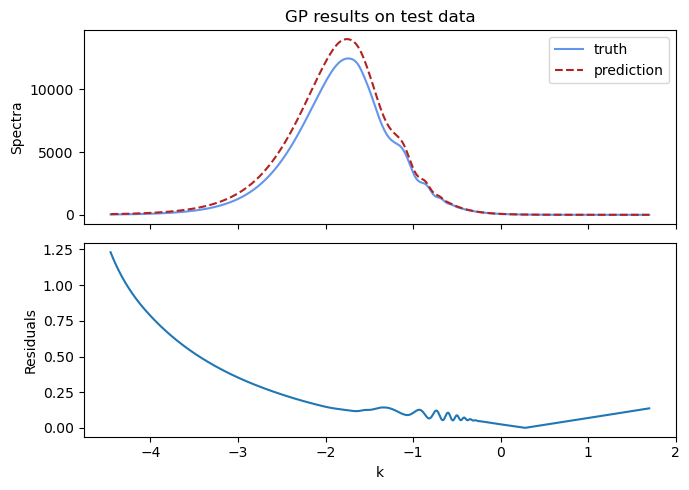

In [53]:
prediction_spectrum_test = (prediction_spectrum_normed_test * binwise_std + binwise_mean) * ref_spectrum
# prediction_spectrum_test = dcl.reconstruct_spectra(prediction_spectrum_normed_test, emulation_data)

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(kgrid, truth_spectrum_test, c='cornflowerblue', label='truth')
ax[0].plot(kgrid, prediction_spectrum_test.flatten(), c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')

residuals = np.abs(1 - prediction_spectrum_test.flatten() / truth_spectrum_test)
ax[1].plot(kgrid, residuals)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Residuals')

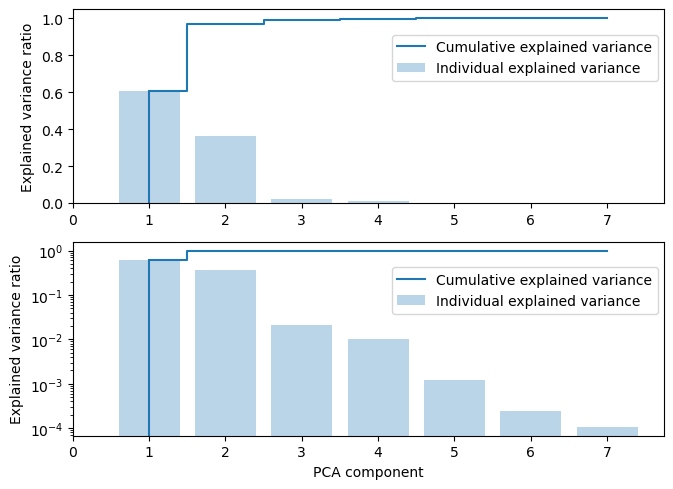

In [65]:
pca = intobj.pca

X_train_pca = pca.fit_transform(trainspace_matrix)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
fig, ax = plt.subplots(2, figsize=(7, 5))
ax[0].step(range(1, len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
ax[0].bar(range(1, len(exp_var_pca)+1), exp_var_pca, alpha=0.3, align='center', label='Individual explained variance')
ax[0].vlines(x=1, ymin=0, ymax=cum_sum_eigenvalues[0])
ax[0].set_ylabel('Explained variance ratio')
ax[0].set_xticks(list(range(npca+1)))
ax[0].legend(loc=(0.54, 0.63))

ax[1].step(range(1, len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
ax[1].bar(range(1, len(exp_var_pca)+1), exp_var_pca, alpha=0.3, align='center', label='Individual explained variance')
ax[1].vlines(x=1, ymin=0, ymax=cum_sum_eigenvalues[0])
ax[1].set_ylabel('Explained variance ratio')
ax[1].set_xlabel('PCA component')
ax[1].set_yscale('log')
ax[1].set_xticks(list(range(npca+1)))
ax[1].legend(loc=(0.54, 0.63))
plt.tight_layout()
plt.show()

In [38]:
# import pickle
# filename = 'gp_Plin_z0to2.sav'
# pickle.dump(intobj, open(filename, 'wb'))